In [2]:
import os
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)
# change to your own directory
os.chdir('/content/drive/My Drive/applied_cv/')

Mounted at /content/drive/


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

## Careful... when unzipping

In [ ]:
%%bash
#pwd
#ls .
#unzip archive.zip


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
DATA_DIR = './100k/'
print(os.listdir(DATA_DIR+'/100k')[:10])

['015093.jpg', '015379.jpg', '015285.jpg', '015244.jpg', '015288.jpg', '014967.jpg', '015405.jpg', '015128.jpg', '015167.jpg', '015328.jpg']


In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # mean, std for normalize imagess

In [6]:
train_ds = ImageFolder(root=DATA_DIR, 
                       transform=T.Compose([T.Resize(image_size),
                                            T.CenterCrop(image_size),
                                            T.ToTensor(),
                                            T.Normalize(*stats)                      
                                        ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [7]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    # pytorch -> matplotlib permutation
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    """ 3 things:
    1. Connected to Nvidia GPU
    2. Cuda drivers
    3. Pytorch suitable to GPU version
    then torch.cuda.is_available is True
    """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
# modificication version 2

latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=1, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)


In [ ]:
## Original Model
"""
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)
"""

'\ngenerator = nn.Sequential(\n    # in: latent_size x 1 x 1\n\n    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),\n    nn.BatchNorm2d(512),\n    nn.ReLU(True),\n    # out: 512 x 4 x 4\n\n    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),\n    nn.BatchNorm2d(256),\n    nn.ReLU(True),\n    # out: 256 x 8 x 8\n\n    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),\n    nn.BatchNorm2d(128),\n    nn.ReLU(True),\n    # out: 128 x 16 x 16\n\n    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),\n    nn.BatchNorm2d(64),\n    nn.ReLU(True),\n    # out: 64 x 32 x 32\n\n    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),\n    nn.Tanh()  # output is between -1 to 1\n    # out: 3 x 64 x 64\n)\n'

torch.Size([3, 64, 64])
torch.Size([128, 3, 64, 64])


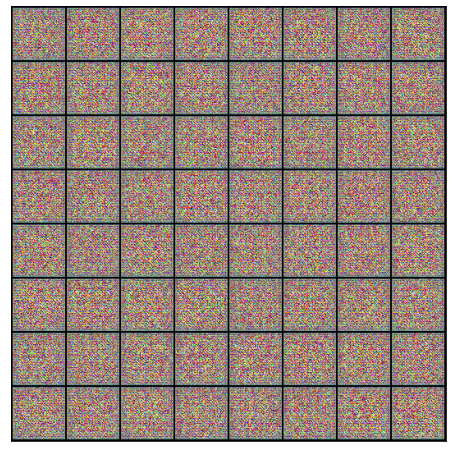

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images[0].shape)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device) 

In [ ]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through  discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass Fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator 
  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
from torchvision.utils import save_image
sample_dir = 'generated_3'
model_dir = 'model_checkpoints_3'
os.makedirs(sample_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated=images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated=images-0000.png


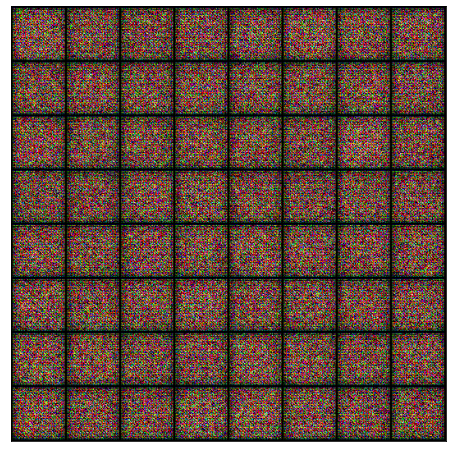

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # Train generator
      loss_g = train_generator(opt_g)
    torch.save(discriminator.state_dict(), model_dir + "/" + "D.pt")
    torch.save(generator.state_dict(), model_dir + "/" + "G.pt")

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
# Hyperparameters
lr = 0.00025
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.9820, loss_d: 0.0902, real_score: 0.9497, fake_score: 0.0328
Saving generated=images-0001.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 1.7183, loss_d: 0.3921, real_score: 0.7839, fake_score: 0.0987
Saving generated=images-0002.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 1.1619, loss_d: 1.7709, real_score: 0.3025, fake_score: 0.0179
Saving generated=images-0003.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 1.5839, loss_d: 1.1328, real_score: 0.3966, fake_score: 0.0800
Saving generated=images-0004.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 2.3542, loss_d: 0.7380, real_score: 0.6801, fake_score: 0.2392
Saving generated=images-0005.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 1.2222, loss_d: 0.9336, real_score: 0.5069, fake_score: 0.1028
Saving generated=images-0006.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 1.4761, loss_d: 0.8498, real_score: 0.5370, fake_score: 0.0830
Saving generated=images-0007.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.4171, loss_d: 0.7316, real_score: 0.6589, fake_score: 0.1802
Saving generated=images-0008.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.1510, loss_d: 0.6141, real_score: 0.7760, fake_score: 0.2579
Saving generated=images-0009.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.6787, loss_d: 0.4863, real_score: 0.7200, fake_score: 0.0910
Saving generated=images-0010.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 7.1159, loss_d: 1.2187, real_score: 0.8673, fake_score: 0.5924
Saving generated=images-0011.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.1721, loss_d: 0.9282, real_score: 0.5064, fake_score: 0.0334
Saving generated=images-0012.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 4.8865, loss_d: 1.0522, real_score: 0.8513, fake_score: 0.5378
Saving generated=images-0013.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 2.0812, loss_d: 0.8060, real_score: 0.6243, fake_score: 0.1911
Saving generated=images-0014.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 2.6216, loss_d: 0.6743, real_score: 0.6795, fake_score: 0.1797
Saving generated=images-0015.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.8019, loss_d: 0.5886, real_score: 0.8826, fake_score: 0.3359
Saving generated=images-0016.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 4.8520, loss_d: 0.7168, real_score: 0.9211, fake_score: 0.4295
Saving generated=images-0017.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 2.4639, loss_d: 0.5797, real_score: 0.6995, fake_score: 0.1436
Saving generated=images-0018.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.9379, loss_d: 0.7899, real_score: 0.7939, fake_score: 0.3635
Saving generated=images-0019.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 4.9450, loss_d: 0.9655, real_score: 0.8326, fake_score: 0.4838
Saving generated=images-0020.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 2.0782, loss_d: 0.8714, real_score: 0.5043, fake_score: 0.0421
Saving generated=images-0021.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.7971, loss_d: 0.9706, real_score: 0.8567, fake_score: 0.4771
Saving generated=images-0022.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 1.4559, loss_d: 0.8582, real_score: 0.5187, fake_score: 0.0793
Saving generated=images-0023.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.8709, loss_d: 0.5798, real_score: 0.8396, fake_score: 0.2954
Saving generated=images-0024.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 2.0335, loss_d: 0.8510, real_score: 0.5143, fake_score: 0.0384
Saving generated=images-0025.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 4.4147, loss_d: 0.8481, real_score: 0.8872, fake_score: 0.4525
Saving generated=images-0026.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.2600, loss_d: 0.5432, real_score: 0.7986, fake_score: 0.2298
Saving generated=images-0027.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.6533, loss_d: 0.6388, real_score: 0.8713, fake_score: 0.3613
Saving generated=images-0028.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 5.6904, loss_d: 0.8561, real_score: 0.9413, fake_score: 0.4996
Saving generated=images-0029.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.1739, loss_d: 0.3421, real_score: 0.8332, fake_score: 0.1199
Saving generated=images-0030.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 5.6694, loss_d: 0.9077, real_score: 0.9788, fake_score: 0.5231
Saving generated=images-0031.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.4194, loss_d: 0.4007, real_score: 0.8313, fake_score: 0.1640
Saving generated=images-0032.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.8595, loss_d: 0.5782, real_score: 0.7351, fake_score: 0.1875
Saving generated=images-0033.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 2.4004, loss_d: 0.5778, real_score: 0.7034, fake_score: 0.1625
Saving generated=images-0034.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.4895, loss_d: 0.5169, real_score: 0.9291, fake_score: 0.3305
Saving generated=images-0035.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 6.3672, loss_d: 0.8247, real_score: 0.9439, fake_score: 0.4869
Saving generated=images-0036.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 2.8850, loss_d: 0.5004, real_score: 0.7988, fake_score: 0.2117
Saving generated=images-0037.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 2.9161, loss_d: 0.5149, real_score: 0.7625, fake_score: 0.1872
Saving generated=images-0038.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 3.4973, loss_d: 0.4369, real_score: 0.9504, fake_score: 0.2815
Saving generated=images-0039.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 2.5288, loss_d: 0.6643, real_score: 0.6887, fake_score: 0.1849
Saving generated=images-0040.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 0.6760, loss_d: 1.3579, real_score: 0.3557, fake_score: 0.0966
Saving generated=images-0041.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 0.7734, loss_d: 1.8150, real_score: 0.2173, fake_score: 0.0086
Saving generated=images-0042.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.7173, loss_d: 0.6068, real_score: 0.8106, fake_score: 0.2988
Saving generated=images-0043.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 6.3551, loss_d: 1.1801, real_score: 0.9740, fake_score: 0.6026
Saving generated=images-0044.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 2.1794, loss_d: 0.5413, real_score: 0.7419, fake_score: 0.1766
Saving generated=images-0045.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 2.7992, loss_d: 0.4132, real_score: 0.8794, fake_score: 0.2188
Saving generated=images-0046.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 2.1655, loss_d: 0.5200, real_score: 0.7147, fake_score: 0.1331
Saving generated=images-0047.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.5548, loss_d: 0.5825, real_score: 0.8670, fake_score: 0.3178
Saving generated=images-0048.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 2.0389, loss_d: 0.9588, real_score: 0.4926, fake_score: 0.0492
Saving generated=images-0049.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 0.5597, loss_d: 0.8554, real_score: 0.4983, fake_score: 0.0730
Saving generated=images-0050.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.3070, loss_d: 0.3960, real_score: 0.9105, fake_score: 0.2414
Saving generated=images-0051.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.1650, loss_d: 0.5413, real_score: 0.9082, fake_score: 0.3213
Saving generated=images-0052.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 4.8268, loss_d: 0.7469, real_score: 0.9039, fake_score: 0.4124
Saving generated=images-0053.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.6577, loss_d: 0.2869, real_score: 0.8418, fake_score: 0.0959
Saving generated=images-0054.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 3.0509, loss_d: 0.3007, real_score: 0.8412, fake_score: 0.0975
Saving generated=images-0055.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 1.7977, loss_d: 0.5876, real_score: 0.6637, fake_score: 0.1133
Saving generated=images-0056.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.4677, loss_d: 0.6969, real_score: 0.7788, fake_score: 0.3006
Saving generated=images-0057.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 2.1342, loss_d: 0.5207, real_score: 0.6428, fake_score: 0.0255
Saving generated=images-0058.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.1482, loss_d: 0.3557, real_score: 0.8757, fake_score: 0.1790
Saving generated=images-0059.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 2.6133, loss_d: 0.3609, real_score: 0.7629, fake_score: 0.0567
Saving generated=images-0060.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 2.5939, loss_d: 0.3178, real_score: 0.9016, fake_score: 0.1672
Saving generated=images-0061.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.0549, loss_d: 0.6691, real_score: 0.8073, fake_score: 0.3070
Saving generated=images-0062.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 1.8847, loss_d: 0.5238, real_score: 0.6648, fake_score: 0.0598
Saving generated=images-0063.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 2.2561, loss_d: 0.3557, real_score: 0.7891, fake_score: 0.0866
Saving generated=images-0064.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 2.7459, loss_d: 0.3667, real_score: 0.8023, fake_score: 0.1137
Saving generated=images-0065.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 2.3399, loss_d: 0.6258, real_score: 0.5992, fake_score: 0.0304
Saving generated=images-0066.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 1.1835, loss_d: 1.7943, real_score: 0.2346, fake_score: 0.0017
Saving generated=images-0067.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 1.8521, loss_d: 0.3491, real_score: 0.7567, fake_score: 0.0407
Saving generated=images-0068.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 2.4960, loss_d: 0.4748, real_score: 0.7226, fake_score: 0.0748
Saving generated=images-0069.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 3.0261, loss_d: 0.2224, real_score: 0.8689, fake_score: 0.0671
Saving generated=images-0070.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 3.2563, loss_d: 0.3288, real_score: 0.8190, fake_score: 0.0984
Saving generated=images-0071.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 5.6884, loss_d: 0.5085, real_score: 0.9587, fake_score: 0.3216
Saving generated=images-0072.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 2.6952, loss_d: 0.3525, real_score: 0.7966, fake_score: 0.0976
Saving generated=images-0073.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 2.5816, loss_d: 0.8497, real_score: 0.5888, fake_score: 0.1635
Saving generated=images-0074.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.5835, loss_d: 0.3605, real_score: 0.8912, fake_score: 0.1901
Saving generated=images-0075.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 5.2085, loss_d: 0.5189, real_score: 0.9769, fake_score: 0.3507
Saving generated=images-0076.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.9651, loss_d: 0.1951, real_score: 0.8909, fake_score: 0.0679
Saving generated=images-0077.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 0.9059, loss_d: 0.9885, real_score: 0.5429, fake_score: 0.1604
Saving generated=images-0078.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 4.5404, loss_d: 0.2942, real_score: 0.9411, fake_score: 0.1900
Saving generated=images-0079.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 3.9631, loss_d: 0.4395, real_score: 0.8998, fake_score: 0.2450
Saving generated=images-0080.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 2.8284, loss_d: 0.2693, real_score: 0.8504, fake_score: 0.0834
Saving generated=images-0081.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 3.6644, loss_d: 0.2941, real_score: 0.9149, fake_score: 0.1698
Saving generated=images-0082.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.5255, loss_d: 0.8259, real_score: 0.7353, fake_score: 0.2753
Saving generated=images-0083.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.5103, loss_d: 0.3534, real_score: 0.7858, fake_score: 0.0776
Saving generated=images-0084.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.3112, loss_d: 0.2554, real_score: 0.8285, fake_score: 0.0457
Saving generated=images-0085.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.3140, loss_d: 0.1655, real_score: 0.9519, fake_score: 0.1038
Saving generated=images-0086.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 2.6274, loss_d: 0.4787, real_score: 0.7306, fake_score: 0.1070
Saving generated=images-0087.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 3.7205, loss_d: 0.2180, real_score: 0.9359, fake_score: 0.1227
Saving generated=images-0088.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 0.8262, loss_d: 1.8025, real_score: 0.2766, fake_score: 0.0571
Saving generated=images-0089.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.5234, loss_d: 0.1751, real_score: 0.9606, fake_score: 0.1174
Saving generated=images-0090.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.2925, loss_d: 0.3267, real_score: 0.7747, fake_score: 0.0468
Saving generated=images-0091.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.1757, loss_d: 0.1621, real_score: 0.9278, fake_score: 0.0786
Saving generated=images-0092.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 4.6509, loss_d: 1.1447, real_score: 0.9277, fake_score: 0.5846
Saving generated=images-0093.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 2.8251, loss_d: 0.3101, real_score: 0.8506, fake_score: 0.1207
Saving generated=images-0094.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.3800, loss_d: 0.1635, real_score: 0.9772, fake_score: 0.1226
Saving generated=images-0095.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 4.9070, loss_d: 0.2389, real_score: 0.9762, fake_score: 0.1783
Saving generated=images-0096.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 2.1898, loss_d: 0.2563, real_score: 0.8382, fake_score: 0.0610
Saving generated=images-0097.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 2.5238, loss_d: 0.8758, real_score: 0.4922, fake_score: 0.0097
Saving generated=images-0098.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 2.7721, loss_d: 0.1847, real_score: 0.8687, fake_score: 0.0334
Saving generated=images-0099.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 4.2623, loss_d: 0.1743, real_score: 0.9649, fake_score: 0.1182
Saving generated=images-0100.png


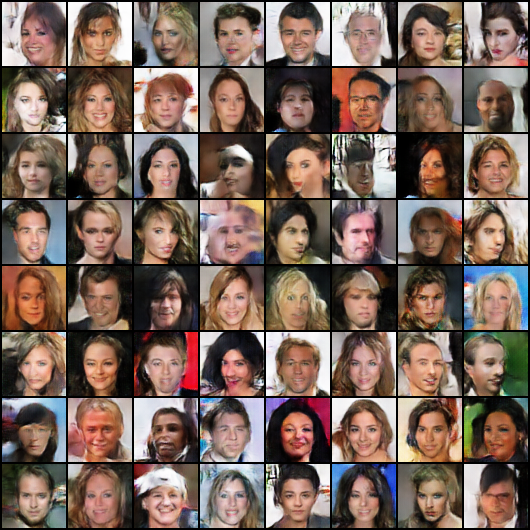

In [ ]:
from IPython.display import Image

Image('./generated_2/generated=images-0100.png')


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history


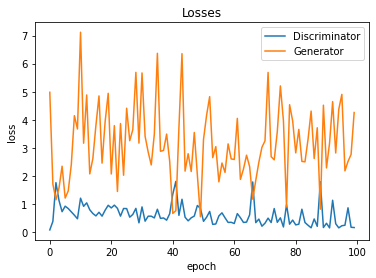

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Version 3

In [ ]:
# modificication verison 3
latent_size = 256

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=1, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

In [ ]:
## Reset discriminator
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device) 

In [ ]:
# Hyperparameters
lr = 0.00025
epochs = 100
history = fit(epochs, lr)

  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 9.3420, loss_d: 0.0691, real_score: 0.9871, fake_score: 0.0520
Saving generated=images-0001.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 4.3004, loss_d: 1.1189, real_score: 0.8918, fake_score: 0.6094
Saving generated=images-0002.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 2.2582, loss_d: 0.8774, real_score: 0.5018, fake_score: 0.0625
Saving generated=images-0003.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 3.9762, loss_d: 0.4572, real_score: 0.8783, fake_score: 0.2634
Saving generated=images-0004.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 4.4002, loss_d: 0.5814, real_score: 0.8376, fake_score: 0.2980
Saving generated=images-0005.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.9637, loss_d: 1.2364, real_score: 0.9693, fake_score: 0.6407
Saving generated=images-0006.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 4.7912, loss_d: 0.7167, real_score: 0.7531, fake_score: 0.2986
Saving generated=images-0007.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 4.7885, loss_d: 0.6433, real_score: 0.8082, fake_score: 0.3056
Saving generated=images-0008.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 5.0832, loss_d: 0.5980, real_score: 0.8990, fake_score: 0.3564
Saving generated=images-0009.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.6454, loss_d: 0.7906, real_score: 0.8327, fake_score: 0.4167
Saving generated=images-0010.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 3.3098, loss_d: 0.5399, real_score: 0.6661, fake_score: 0.0778
Saving generated=images-0011.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.7573, loss_d: 0.4920, real_score: 0.7017, fake_score: 0.0975
Saving generated=images-0012.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 3.3394, loss_d: 0.5732, real_score: 0.7623, fake_score: 0.2125
Saving generated=images-0013.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 1.9340, loss_d: 0.8459, real_score: 0.5271, fake_score: 0.0922
Saving generated=images-0014.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 2.0202, loss_d: 0.6570, real_score: 0.7127, fake_score: 0.1811
Saving generated=images-0015.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 2.3878, loss_d: 0.9071, real_score: 0.4968, fake_score: 0.0499
Saving generated=images-0016.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.9994, loss_d: 0.4107, real_score: 0.8198, fake_score: 0.1635
Saving generated=images-0017.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 1.9419, loss_d: 0.9890, real_score: 0.5023, fake_score: 0.1252
Saving generated=images-0018.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.3226, loss_d: 0.5062, real_score: 0.7161, fake_score: 0.1159
Saving generated=images-0019.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 4.4958, loss_d: 0.4205, real_score: 0.7902, fake_score: 0.0980
Saving generated=images-0020.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 4.6346, loss_d: 0.7408, real_score: 0.8592, fake_score: 0.4026
Saving generated=images-0021.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 2.2666, loss_d: 0.5551, real_score: 0.6885, fake_score: 0.1032
Saving generated=images-0022.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 3.1942, loss_d: 0.4867, real_score: 0.7873, fake_score: 0.1890
Saving generated=images-0023.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 5.6758, loss_d: 0.6913, real_score: 0.9176, fake_score: 0.4092
Saving generated=images-0024.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.3759, loss_d: 0.5970, real_score: 0.7689, fake_score: 0.2317
Saving generated=images-0025.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 3.1530, loss_d: 0.4995, real_score: 0.7733, fake_score: 0.1646
Saving generated=images-0026.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.3631, loss_d: 0.4854, real_score: 0.7344, fake_score: 0.0997
Saving generated=images-0027.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 4.2522, loss_d: 0.6190, real_score: 0.9120, fake_score: 0.3593
Saving generated=images-0028.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 5.3883, loss_d: 0.6613, real_score: 0.9093, fake_score: 0.3926
Saving generated=images-0029.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 4.4516, loss_d: 0.3286, real_score: 0.9203, fake_score: 0.1999
Saving generated=images-0030.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 2.3009, loss_d: 0.5819, real_score: 0.6229, fake_score: 0.0460
Saving generated=images-0031.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 2.1912, loss_d: 0.4236, real_score: 0.8270, fake_score: 0.1590
Saving generated=images-0032.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.4267, loss_d: 0.5624, real_score: 0.9474, fake_score: 0.3588
Saving generated=images-0033.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 1.5016, loss_d: 0.8439, real_score: 0.5507, fake_score: 0.1215
Saving generated=images-0034.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.5124, loss_d: 0.4179, real_score: 0.8179, fake_score: 0.1682
Saving generated=images-0035.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.9139, loss_d: 0.2545, real_score: 0.8615, fake_score: 0.0807
Saving generated=images-0036.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 5.0138, loss_d: 0.6026, real_score: 0.9690, fake_score: 0.3876
Saving generated=images-0037.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.7221, loss_d: 0.5005, real_score: 0.6757, fake_score: 0.0420
Saving generated=images-0038.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 1.8546, loss_d: 0.7145, real_score: 0.5781, fake_score: 0.0502
Saving generated=images-0039.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 1.2385, loss_d: 1.2967, real_score: 0.3464, fake_score: 0.0112
Saving generated=images-0040.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.8952, loss_d: 0.7088, real_score: 0.9354, fake_score: 0.4260
Saving generated=images-0041.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 3.3710, loss_d: 0.5556, real_score: 0.7759, fake_score: 0.1969
Saving generated=images-0042.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.1370, loss_d: 0.4563, real_score: 0.9324, fake_score: 0.2898
Saving generated=images-0043.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.6338, loss_d: 0.6375, real_score: 0.9349, fake_score: 0.3954
Saving generated=images-0044.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 3.2386, loss_d: 0.3486, real_score: 0.8449, fake_score: 0.1396
Saving generated=images-0045.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 0.6610, loss_d: 2.0397, real_score: 0.1811, fake_score: 0.0046
Saving generated=images-0046.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 4.2350, loss_d: 0.4970, real_score: 0.9551, fake_score: 0.3311
Saving generated=images-0047.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.6494, loss_d: 0.3464, real_score: 0.9184, fake_score: 0.2086
Saving generated=images-0048.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 2.8627, loss_d: 0.8303, real_score: 0.5655, fake_score: 0.1151
Saving generated=images-0049.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 1.1461, loss_d: 0.4982, real_score: 0.7007, fake_score: 0.1001
Saving generated=images-0050.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.4563, loss_d: 0.5740, real_score: 0.7901, fake_score: 0.2248
Saving generated=images-0051.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 3.3950, loss_d: 0.3733, real_score: 0.8631, fake_score: 0.1807
Saving generated=images-0052.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 2.7064, loss_d: 0.4244, real_score: 0.7363, fake_score: 0.0772
Saving generated=images-0053.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.6848, loss_d: 0.4901, real_score: 0.6880, fake_score: 0.0452
Saving generated=images-0054.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 2.1514, loss_d: 0.4342, real_score: 0.7148, fake_score: 0.0558
Saving generated=images-0055.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 1.5233, loss_d: 0.4181, real_score: 0.7708, fake_score: 0.1169
Saving generated=images-0056.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.6184, loss_d: 0.5306, real_score: 0.6828, fake_score: 0.0777
Saving generated=images-0057.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.5304, loss_d: 0.4455, real_score: 0.9207, fake_score: 0.2814
Saving generated=images-0058.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.9677, loss_d: 0.5807, real_score: 0.8438, fake_score: 0.2930
Saving generated=images-0059.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 4.7667, loss_d: 0.6549, real_score: 0.9466, fake_score: 0.3844
Saving generated=images-0060.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.1877, loss_d: 0.9879, real_score: 0.9319, fake_score: 0.5300
Saving generated=images-0061.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.5606, loss_d: 0.3902, real_score: 0.9261, fake_score: 0.2382
Saving generated=images-0062.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 2.5512, loss_d: 0.7709, real_score: 0.5336, fake_score: 0.0078
Saving generated=images-0063.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.9984, loss_d: 0.3321, real_score: 0.8054, fake_score: 0.0848
Saving generated=images-0064.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.1618, loss_d: 0.2821, real_score: 0.8948, fake_score: 0.1427
Saving generated=images-0065.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.3360, loss_d: 0.3137, real_score: 0.9052, fake_score: 0.1729
Saving generated=images-0066.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 4.0377, loss_d: 0.3009, real_score: 0.9325, fake_score: 0.1934
Saving generated=images-0067.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.0357, loss_d: 0.6901, real_score: 0.8113, fake_score: 0.3185
Saving generated=images-0068.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 2.6378, loss_d: 0.3250, real_score: 0.8094, fake_score: 0.0858
Saving generated=images-0069.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 1.7351, loss_d: 0.2842, real_score: 0.8270, fake_score: 0.0732
Saving generated=images-0070.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 1.5650, loss_d: 0.6620, real_score: 0.6059, fake_score: 0.0770
Saving generated=images-0071.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 5.2517, loss_d: 1.4384, real_score: 0.9832, fake_score: 0.6235
Saving generated=images-0072.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 4.2472, loss_d: 0.2988, real_score: 0.9548, fake_score: 0.2027
Saving generated=images-0073.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 2.3118, loss_d: 0.3542, real_score: 0.7640, fake_score: 0.0450
Saving generated=images-0074.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 3.1746, loss_d: 0.2347, real_score: 0.9416, fake_score: 0.1363
Saving generated=images-0075.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.2703, loss_d: 0.3225, real_score: 0.7679, fake_score: 0.0288
Saving generated=images-0076.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.5680, loss_d: 0.2657, real_score: 0.8926, fake_score: 0.1236
Saving generated=images-0077.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.5233, loss_d: 0.3306, real_score: 0.8142, fake_score: 0.0945
Saving generated=images-0078.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 1.3787, loss_d: 1.3310, real_score: 0.4271, fake_score: 0.1188
Saving generated=images-0079.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.3886, loss_d: 0.6099, real_score: 0.6045, fake_score: 0.0193
Saving generated=images-0080.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.2614, loss_d: 0.4408, real_score: 0.9212, fake_score: 0.2678
Saving generated=images-0081.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 4.6393, loss_d: 0.2649, real_score: 0.9617, fake_score: 0.1840
Saving generated=images-0082.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.8830, loss_d: 0.4512, real_score: 0.7056, fake_score: 0.0359
Saving generated=images-0083.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 2.7110, loss_d: 0.5292, real_score: 0.6300, fake_score: 0.0100
Saving generated=images-0084.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 2.0420, loss_d: 0.8098, real_score: 0.5363, fake_score: 0.0332
Saving generated=images-0085.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 3.6321, loss_d: 0.3720, real_score: 0.8832, fake_score: 0.1838
Saving generated=images-0086.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 2.7142, loss_d: 0.2915, real_score: 0.8021, fake_score: 0.0484
Saving generated=images-0087.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 5.2995, loss_d: 0.2920, real_score: 0.9714, fake_score: 0.2112
Saving generated=images-0088.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.3464, loss_d: 0.4731, real_score: 0.8923, fake_score: 0.2552
Saving generated=images-0089.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.6641, loss_d: 0.3045, real_score: 0.9717, fake_score: 0.2168
Saving generated=images-0090.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.4518, loss_d: 0.2235, real_score: 0.8469, fake_score: 0.0431
Saving generated=images-0091.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 5.3977, loss_d: 0.4741, real_score: 0.9602, fake_score: 0.3133
Saving generated=images-0092.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 2.7072, loss_d: 0.2770, real_score: 0.8474, fake_score: 0.0869
Saving generated=images-0093.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 2.4828, loss_d: 0.7290, real_score: 0.6684, fake_score: 0.1766
Saving generated=images-0094.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 4.2895, loss_d: 0.1986, real_score: 0.9266, fake_score: 0.1044
Saving generated=images-0095.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.1072, loss_d: 0.2350, real_score: 0.8179, fake_score: 0.0156
Saving generated=images-0096.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 1.0399, loss_d: 1.1970, real_score: 0.3886, fake_score: 0.0326
Saving generated=images-0097.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 7.7767, loss_d: 3.3722, real_score: 0.9989, fake_score: 0.9186
Saving generated=images-0098.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 3.3652, loss_d: 0.4722, real_score: 0.7127, fake_score: 0.0317
Saving generated=images-0099.png


  0%|          | 0/68 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 3.6948, loss_d: 0.1819, real_score: 0.9391, fake_score: 0.1030
Saving generated=images-0100.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history


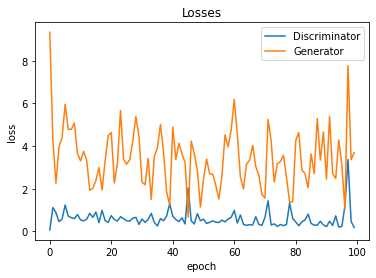

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

No convergence?

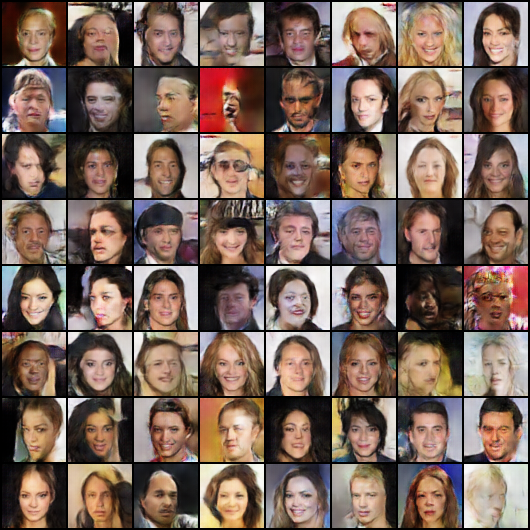

In [ ]:
from IPython.display import Image

Image('./generated_3/generated=images-0100.png')